In [1]:
import BatSim.New_Hamiltonian.Noisy_Passive_Unitary        as data
import BatSim.New_Hamiltonian.Noisy_Passive_Circuit        as datac
import BatSim.New_Hamiltonian.Theory_Unconditional         as datae
import BatSim.New_Hamiltonian.Implementation_Unconditional as datad
from math import pi
from qiskit_aer import AerSimulator

c:\Users\Navid Elyasi\AppData\Local\Programs\Python\Python310\lib\site-packages\qutip\__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
import BatSim.New_Hamiltonian.test as test

In [3]:
test

<module 'BatSim.New_Hamiltonian.test' from 'e:\\Thesis\\Prof.Marco Genoni\\OQB-implementation---Batsim\\BatSim\\New_Hamiltonian\\test.py'>

In [4]:
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b8c9c6ea75f73002df04d5bf97273f3d153a43c11b611279642b752989d86cfad0e023990964d294f3b43317b04c44e1d6290c6cb30514aad5014932ca197a8b", overwrite=True)
#If you want run the code on the simulator, please enable the following line. If you wan to run it on the real backend, let it go to be disabled. 



# Define Initial Parameters

In [5]:
from math import sqrt, exp
from qiskit import *
Steps  = 10
Charge = 8*pi/10
Battery = 28
Ancilla = 29
omega = 1
kappa = 1
shots = 10000

# Conditional Passive Energy 

In [6]:

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.get_backend('ibm_osaka')
properties = backend.properties()
backend_data = properties.to_dict()
#P01 = backend_data['qubits'][Ancilla][5]['value']
#P10 = backend_data['qubits'][Ancilla][6]['value']
backend = AerSimulator().from_backend(backend)
#Circuit For Calculating P01
q  = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)
qc.x(q)
qc.measure(q, c)
qc = transpile(qc, backend,  initial_layout = [Ancilla])
job = backend.run(qc, shots = 10000)
result = job.result()
counts = result.get_counts()
P01 = counts['0']/10000
#Circuit Fo Claculating P10
q  = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)
qc.measure(q, c)
qc = transpile(qc,backend,  initial_layout = [Ancilla])
job = backend.run(qc, shots = 10000)
result = job.result()
counts = result.get_counts()
P10 = counts['1']/10000
#Extracing the T1 and T2
pa = 1 -  exp(-0.66/(backend_data['qubits'][Battery][0]['value']))
pd = exp(-0.66/(backend_data['qubits'][Battery][1]['value']))
print(P01, P10, pa, pd)

#Inserting the obtained values into our protocol
Passvie_Theory = data.Noisy_Passive_Unitary(Steps = 10, omega = omega, kappa = kappa, pa = pa , pd = pd, P01 =P01 , P10 = P10)
Passive_Im = datac.Noisy_Passive_Circuit(Steps = 10, omega = omega, kappa = kappa, p = pd, backend=backend, shots= shots, qubits =[Battery, Ancilla])


0.0083 0.0059 0.0020864271206184615 0.9829149686174864


In [7]:
Passive_Im

[0.027000000000000024,
 0.045599999999999974,
 0.051100000000000034,
 0.052200000000000024,
 0.056499999999999995,
 0.05740000000000001,
 0.05510000000000004,
 0.05889999999999995,
 0.05379999999999996,
 0.05840000000000001]

In [8]:
Passvie_Theory

[0.017413445282965973,
 0.027391649531997096,
 0.03188778625521528,
 0.04463762692618557,
 0.04461911015825796,
 0.05266847597852743,
 0.05016134698476625,
 0.05339773759704697,
 0.05140085140995853,
 0.05222696248542849]

# Charged Energy and Unconditional Ergotropy

In [9]:
Energy_Theory, Ergotropy_Theory     = datae.Energy_Ergotropy(Steps = Steps,  omega = omega, kappa = kappa, pa = pa , pd = pd)
Energy_Im    , Ergotropy_Im     = datad.Energy_Ergotropy(Steps = Steps,  omega = omega, kappa = kappa , backend = backend, shots = shots, qubits = [Battery, Ancilla])
#Energy_Im = Energy_Theory
#Ergotropy_Im = Ergotropy_Theory




# Daemonic Ergotropy

In [10]:
Daemonic_Theory = [xi - yi for xi, yi in zip(Energy_Theory, Passvie_Theory )]
Daemonic_Im     = [xi - yi for xi, yi in zip(Energy_Im    ,      Passive_Im)]

x_axis = []
x  = 0
for k in range(Steps):
    x += 1
    x_axis.append(x)

# Plotting the Results 

c:\Users\Navid Elyasi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Navid Elyasi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


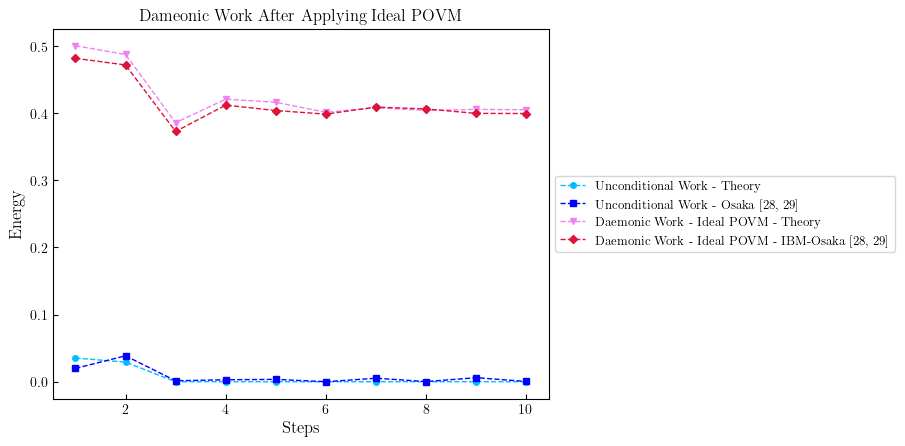

In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams['font.family'] = "serif"
plt.rcParams['text.usetex'] = True
font = {'family': 'serif',
        'weight': 'normal',
        'size': 9,
        }
#font = font_manager.FontProperties(family='serif',style='normal', size=12)

plt.plot(x_axis, Ergotropy_Theory, color='deepskyblue', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='deepskyblue', markersize=4, label = "Unconditional Work - Theory")
         
plt.plot(x_axis, Ergotropy_Im  , color='blue', linestyle='dashed', linewidth = 1,
         marker='s', markerfacecolor='blue', markersize=4, label = "Unconditional Work - Osaka [28, 29]")

plt.plot(x_axis, Daemonic_Theory, color='violet', linestyle='dashed', linewidth = 1,
         marker= "v", markerfacecolor='violet', markersize=4,  label = "Daemonic Work - Ideal POVM - Theory")

#plt.plot(x_axis, Daemonic_Theory1, color='orange', linestyle='dashed', linewidth = 1,
         #marker= "v", markerfacecolor='orange', markersize=4,  label = "Daemonic Work -Ideal POVM - Theory")

plt.plot(x_axis, Daemonic_Im, color='crimson', linestyle='dashed', linewidth = 1,
         marker= "D", markerfacecolor='crimson', markersize=4    ,label = "Daemonic Work - Ideal POVM - IBM-Osaka [28, 29]")

#plt.plot(x_axis, Daemonic_Im1, color='green', linestyle='dashed', linewidth = 1,
         #marker= "D", markerfacecolor='green', markersize=4    ,label = "Daemonic Work - Ideal POVM - IBM-Osaka [28, 29]") 

plt.xlabel('Steps', fontdict=font, fontsize=12)
plt.ylabel('Energy', fontdict=font, fontsize=12)
plt.title(f'Dameonic Work After Applying Ideal POVM', fontdict=font,fontsize=12 )
plt.tick_params(direction = 'in', which = 'both') 
plt.tick_params(which='minor', length=4, color='r')
ax = plt.subplot(111)
box = ax.get_position()
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

 #Put a legend to the right of the current axis
ax.legend(loc='center left',bbox_to_anchor=(1, 0.5),  prop = font)
plt.savefig('Plot2legend.pdf',format="pdf",  dpi = 600,  bbox_inches='tight')
plt.show()


In [12]:
Ergotropy_Im 

[0.01979999999999993,
 0.03859999999999997,
 0.0013999999999999568,
 0.002899999999999958,
 0.0035000000000000586,
 0,
 0.005199999999999982,
 0.00019999999999997797,
 0.006000000000000061,
 0.00040000000000001146]

In [13]:
Daemonic_Im  

[0.48149999999999993,
 0.4716,
 0.37259999999999993,
 0.41179999999999994,
 0.40370000000000006,
 0.3984,
 0.40889999999999993,
 0.4061,
 0.3995000000000001,
 0.3993]

In [14]:
Energy_Im 

[0.5085,
 0.5172,
 0.42369999999999997,
 0.46399999999999997,
 0.46020000000000005,
 0.4558,
 0.46399999999999997,
 0.46499999999999997,
 0.45330000000000004,
 0.4577]